In [9]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install ultralytics pillow

Looking in indexes: https://download.pytorch.org/whl/cpu


In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from ultralytics import YOLO
from PIL import Image
import glob
import xml.etree.ElementTree as ET
import shutil

In [11]:
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

In [12]:
def convert_xml_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    
    labels = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height
        
        labels.append(f"0 {x_center} {y_center} {w} {h}")
    
    return labels

In [13]:
xml_files = glob.glob(r'archive (2)\State-wise_OLX\*\*.xml')
total = len(xml_files)
train_split = int(0.8 * total)

print(f'Total annotations: {total}')
print(f'Train: {train_split}, Val: {total - train_split}')

Total annotations: 603
Train: 482, Val: 121


In [14]:
count = 0
for idx, xml_file in enumerate(xml_files):
    labels = convert_xml_to_yolo(xml_file)
    
    img_file = xml_file.replace('.xml', '.jpg')
    if not os.path.exists(img_file):
        img_file = xml_file.replace('.xml', '.jpeg')
    if not os.path.exists(img_file):
        img_file = xml_file.replace('.xml', '.png')
    if not os.path.exists(img_file):
        continue
    
    split = 'train' if idx < train_split else 'val'
    
    base_name = os.path.basename(img_file)
    shutil.copy(img_file, f'dataset/images/{split}/{base_name}')
    
    with open(f'dataset/labels/{split}/{os.path.splitext(base_name)[0]}.txt', 'w') as f:
        f.write('\n'.join(labels))
    
    count += 1

print(f'Dataset prepared! {count} images copied.')

Dataset prepared! 602 images copied.


In [15]:
yaml_content = """
path: dataset
train: images/train
val: images/val

nc: 1
names: ['license_plate']
"""

with open('dataset.yaml', 'w') as f:
    f.write(yaml_content)

print('Config file created!')

Config file created!


In [16]:
model = YOLO('yolov8n.pt')
results = model.train(data='dataset.yaml', epochs=50, imgsz=416, batch=4, device='cpu', patience=5)

New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.13.5 torch-2.7.1+cu118 CPU (Intel Core i5-9300HF 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=Fa

In [18]:
import glob
trained_models = glob.glob('runs/detect/*/weights/best.pt')
if trained_models:
    print('Trained models found:')
    for m in trained_models:
        print(f'  {m}')
    latest_model = max(trained_models, key=os.path.getctime)
    print(f'\nLatest model: {latest_model}')
else:
    print('No trained models found yet. Please run the training cell first.')

Trained models found:
  runs/detect\train5\weights\best.pt

Latest model: runs/detect\train5\weights\best.pt


In [19]:
trained_models = glob.glob('runs/detect/*/weights/best.pt')
latest_model = max(trained_models, key=os.path.getctime)

model = YOLO(latest_model)
test_img = r'archive (2)\State-wise_OLX\MH\MH1.jpg'
results = model.predict(test_img, save=True, conf=0.25)
print('Detection completed! Check runs/detect/predict folder')


image 1/1 e:\trafficwitholddata\archive (2)\State-wise_OLX\MH\MH1.jpg: 288x416 1 license_plate, 68.1ms
Speed: 2.8ms preprocess, 68.1ms inference, 13.0ms postprocess per image at shape (1, 3, 288, 416)
Results saved to E:\trafficwitholddata\runs\detect\predict
Detection completed! Check runs/detect/predict folder



image 1/1 e:\trafficwitholddata\blurred.jpg: 256x416 1 license_plate, 72.8ms
Speed: 2.2ms preprocess, 72.8ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)
Results saved to E:\trafficwitholddata\runs\detect\predict3
image 1/1 e:\trafficwitholddata\blurred.jpg: 256x416 1 license_plate, 72.8ms
Speed: 2.2ms preprocess, 72.8ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 416)
Results saved to E:\trafficwitholddata\runs\detect\predict3


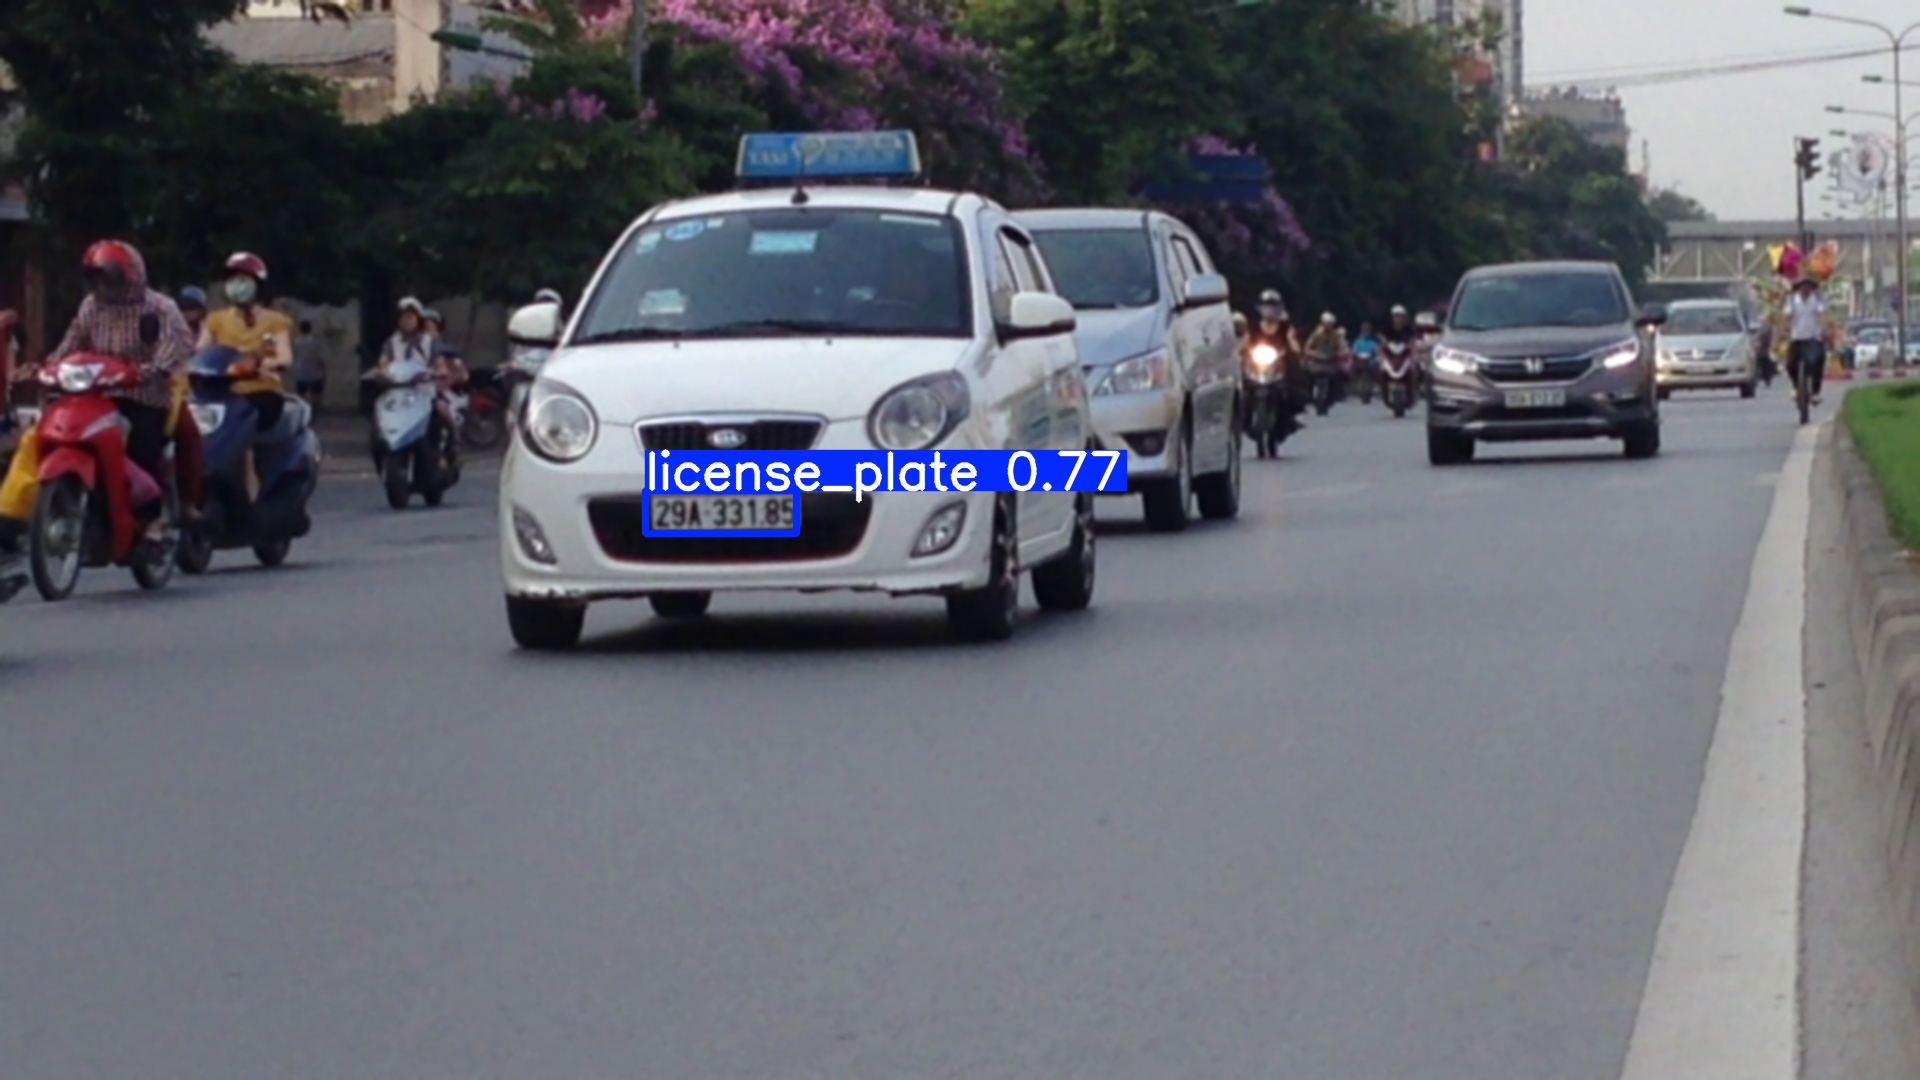

Saved to: E:\trafficwitholddata\runs\detect\predict3\blurred.jpg


In [21]:
test_image = r'blurred.jpg'

trained_models = glob.glob('runs/detect/*/weights/best.pt')
latest_model = max(trained_models, key=os.path.getctime)

model = YOLO(latest_model)
results = model.predict(test_image, save=True, conf=0.25)

from IPython.display import Image as IPImage, display
from pathlib import Path
result_path = Path(results[0].save_dir) / Path(test_image).name
display(IPImage(filename=str(result_path)))
print(f'Saved to: {result_path}')